In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard, BackupAndRestore, TerminateOnNaN
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score 
from tensorflow.keras.metrics import Precision, Recall, AUC, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, MeanSquaredError, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image   
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  0


In [3]:
!nvidia-smi

Wed Dec 25 20:57:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P0             15W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Path creation

In [4]:
def number_in_dir(path):
    return len([file for file in os.listdir(path) if not file.startswith('.')])

project_path = r"D:\Projects\Pneumonia_ML-Tensorflow"
train_path = project_path + r"/chest_xray/train-gpu/"
val_path = project_path + r"/chest_xray/val/"
test_path = project_path + r"/chest_xray/test/"

train_normal_path = train_path + r'NORMAL/'
train_pneumonia_path = train_path + r'PNEUMONIA/'
train_normal_len = number_in_dir(train_normal_path)
train_pneumonia_len = number_in_dir(train_pneumonia_path)
train_sum_len = train_normal_len + train_pneumonia_len

val_normal_path = val_path + r'NORMAL/'
val_pneumonia_path = val_path + r'PNEUMONIA/'
val_normal_len = number_in_dir(val_normal_path)
val_pneumonia_len = number_in_dir(val_pneumonia_path)
val_sum_len = val_normal_len + val_pneumonia_len

test_normal_path = test_path + r'NORMAL/'
test_pneumonia_path = test_path + r'PNEUMONIA/'
test_normal_len = number_in_dir(test_normal_path)
test_pneumonia_len = number_in_dir(test_pneumonia_path)
test_sum_len = test_normal_len + test_pneumonia_len

print("[Train] Number of NORMAL Images: ", train_normal_len)
print("[Train] Number of PNEUMONIA Images: ", train_pneumonia_len)
print("[Train] Number of TOTAL Images: ", train_sum_len)

print("[Test] Number of NORMAL Images: ", test_normal_len)
print("[Test] Number of PNEUMONIA Images: ", test_pneumonia_len)
print("[Test] Number of TOTAL Images: ", test_sum_len)

print("[Validation] Number of NORMAL Images: ", val_normal_len)
print("[Validation] Number of PNEUMONIA Images: ", val_pneumonia_len)
print("[Validation] Number of TOTAL Images: ", val_sum_len)

[Train] Number of NORMAL Images:  3656
[Train] Number of PNEUMONIA Images:  11875
[Train] Number of TOTAL Images:  15531
[Test] Number of NORMAL Images:  244
[Test] Number of PNEUMONIA Images:  420
[Test] Number of TOTAL Images:  664
[Validation] Number of NORMAL Images:  617
[Validation] Number of PNEUMONIA Images:  1773
[Validation] Number of TOTAL Images:  2390


Adding and splitting pneumonia data 

In [5]:
# pneumonia_images_path = r"D:\Projects\Pneumonia_ML-Tensorflow\images"
# 
# new_images = [f for f in os.listdir(pneumonia_images_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
# 
# # Split the data into 80% train-gpu and 20% test_val
# train_images, test_val_images = train_test_split(new_images, test_size=0.2, random_state=42)
# 
# # Further split the 20% test_val into 50% validation and 50% test
# val_images, test_images = train_test_split(test_val_images, test_size=0.5, random_state=42)
# 
# # Function to move images to their respective directories
# def move_images(image_list, source_dir, dest_dir):
#     if not os.path.exists(dest_dir):
#         os.makedirs(dest_dir)
#     for image in image_list:
#         shutil.move(os.path.join(source_dir, image), os.path.join(dest_dir, image))
# 
# # Move the images to their respective directories
# move_images(train_images, pneumonia_images_path, train_pneumonia_path) 
# move_images(val_images, pneumonia_images_path, val_pneumonia_path)
# move_images(test_images, pneumonia_images_path, test_pneumonia_path)
# 
# print(f"Moved {len(train_images)} images to training set.")
# print(f"Moved {len(val_images)} images to validation set.")
# print(f"Moved {len(test_images)} images to test set.")

Adding and splitting normal data 

In [6]:
# normal_images_path = r"D:\Projects\Pneumonia_ML-Tensorflow\images"
# 
# new_images = [f for f in os.listdir(normal_images_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
# 
# # Split the data into 80% train-gpu and 20% test_val
# train_images, test_val_images = train_test_split(new_images, test_size=0.2, random_state=42)
# 
# # Further split the 20% test_val into 50% validation and 50% test
# val_images, test_images = train_test_split(test_val_images, test_size=0.5, random_state=42)
# 
# # Function to move images to their respective directories
# def move_images(image_list, source_dir, dest_dir):
#     if not os.path.exists(dest_dir):
#         os.makedirs(dest_dir)
#     for image in image_list:
#         shutil.move(os.path.join(source_dir, image), os.path.join(dest_dir, image))
# 
# # Move the images to their respective directories
# move_images(train_images, normal_images_path, train_normal_path) 
# move_images(val_images, normal_images_path, val_normal_path)
# move_images(test_images, normal_images_path, test_normal_path)
# 
# print(f"Moved {len(train_images)} images to training set.")
# print(f"Moved {len(val_images)} images to validation set.")
# print(f"Moved {len(test_images)} images to test set.")

Deleting corrupted photos

In [7]:
# path_list = [val_normal_path, val_pneumonia_path,
#              test_normal_path, test_pneumonia_path,
#              train_normal_path, train_pneumonia_path]
# ll = []
# 
# for path in path_list:
#     filenames = [f for f in os.listdir(path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
#     for filename in filenames:
#         file_path = os.path.join(path, filename)
#         try:
#             img = tf.io.read_file(file_path)
#             img = tf.image.decode_png(img)
#         except Exception as e:
#             #os.remove(file_Path)
#             print(f"Deleting {filename}, error: {e}")
#             ll.append(filename)
# 
# print("Number of problematic files:", len(ll))

Comparing photos 

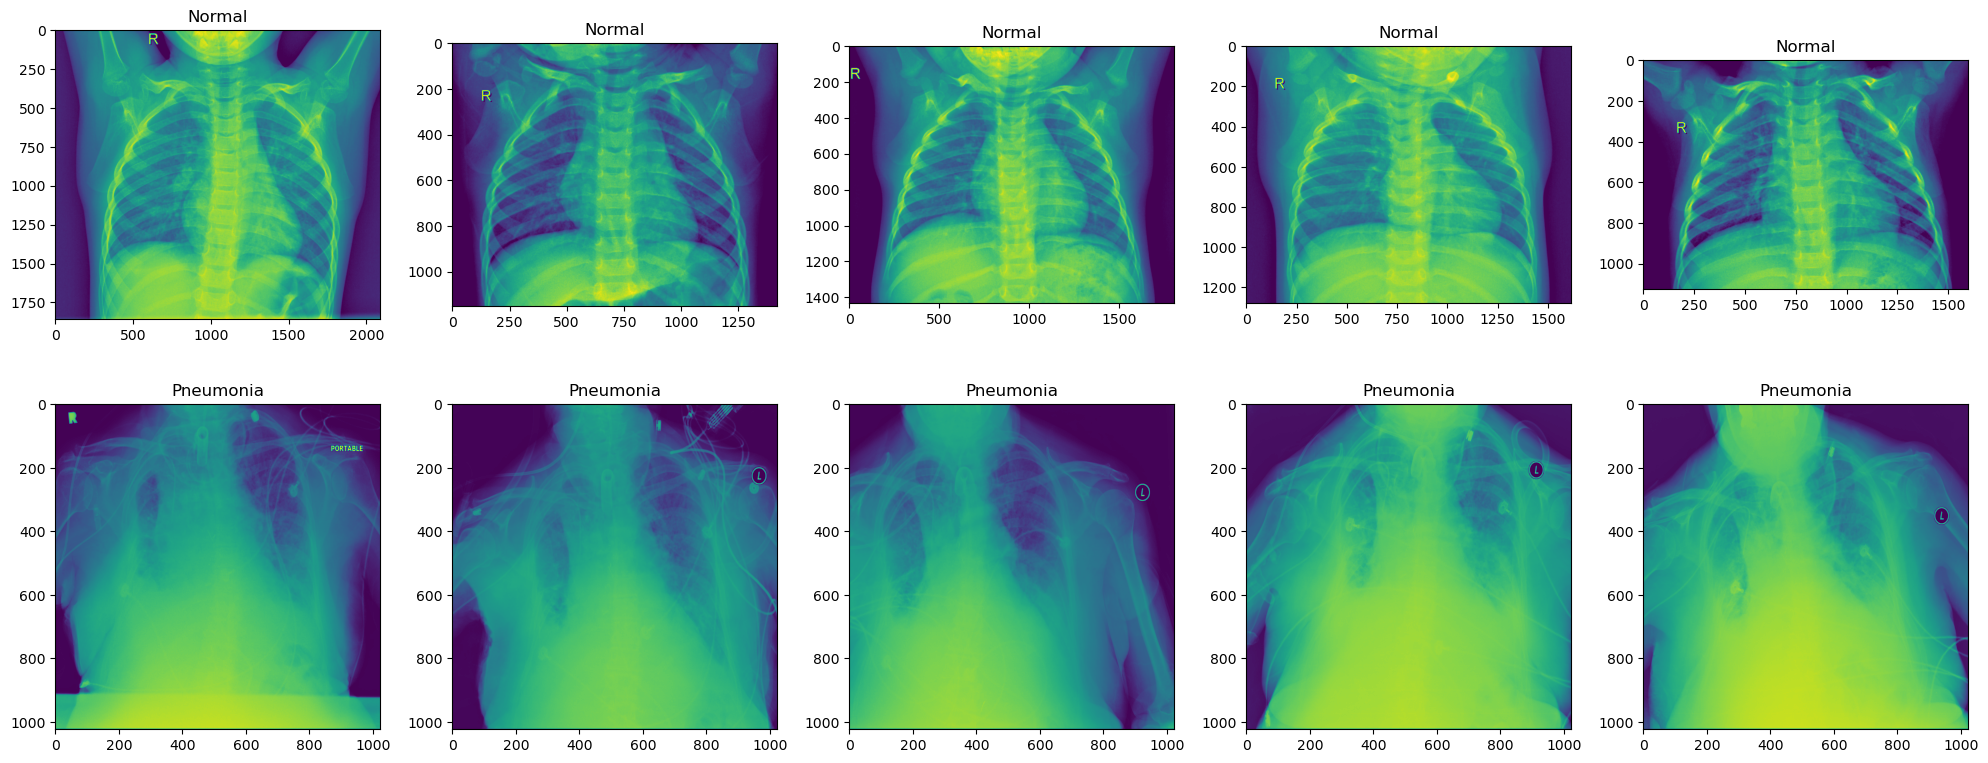

In [8]:
plt.figure(figsize=(20, 8))
num = 5
for index in range(num):
    norm_img_title = os.listdir(train_normal_path)[index]
    norm_img_path = train_normal_path + norm_img_title
    
    plt.subplot(2, num, index+1)
    plt.imshow(Image.open(norm_img_path))
    plt.title('Normal')
    
    pneum_img_title = os.listdir(train_pneumonia_path)[index]
    pneum_img_path = train_pneumonia_path + pneum_img_title
    
    plt.subplot(2, num, index+num+1)
    plt.imshow(Image.open(pneum_img_path))
    plt.title('Pneumonia')
plt.tight_layout()
plt.show()

Percentage statistic in Dataset

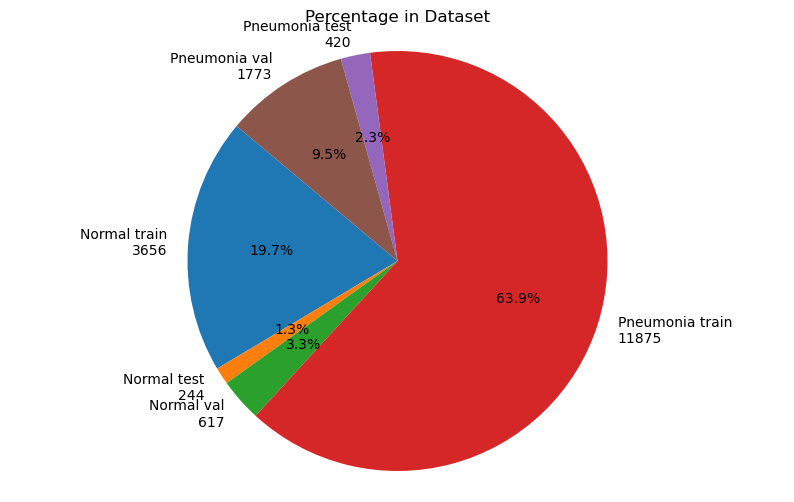

In [9]:
categories = [f'Normal train-gpu\n{train_normal_len}', f'Normal test\n{test_normal_len}', 
              f'Normal val\n{val_normal_len}', f'Pneumonia train-gpu\n{train_pneumonia_len}', 
              f'Pneumonia test\n{test_pneumonia_len}', f'Pneumonia val\n{val_pneumonia_len}']

image_counts = [train_normal_len, test_normal_len, val_normal_len, train_pneumonia_len, test_pneumonia_len, val_pneumonia_len]  
plt.figure(figsize=(10, 6))
plt.pie(image_counts, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Percentage in Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Func for creating chart

In [10]:
def create_charts(model, history, test_dataset):
    # Define train-gpu & validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Define train-gpu & validation AUC
    train_auc_name = list(history.history.keys())[3]
    val_auc_name = list(history.history.keys())[1]
    train_auc = history.history[train_auc_name]
    val_auc = history.history[val_auc_name]
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Extract true labels and make predictions
    y_true = []
    y_pred_prob = []

    # Handle tuple dataset structure (images, labels)
    for images, labels in test_dataset:
        y_true.extend(labels.numpy().flatten())
        y_pred_prob.extend(model.predict(images).flatten())

    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Check label distribution in `y_true`
    unique, counts = np.unique(y_true, return_counts=True)
    print(f"Label distribution in y_true: {dict(zip(unique, counts))}")

    # Plot
    plt.figure(figsize=(20, 18))

    # Plot 1: Train vs. Validation Loss 
    plt.subplot(3, 2, 1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss', marker='o')
    plt.plot(val_loss, label='validation loss', marker='+')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    # Plot 2: Train vs. Validation AUC
    plt.subplot(3, 2, 2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc', marker='o')
    plt.plot(val_auc, label='validation auc', marker='+')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    # Plot 3: Confusion Matrix
    plt.subplot(3, 2, 3)
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    counts = [value for value in cm.flatten()]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, percentages, counts)]
    labels = np.asarray(labels).reshape(2, 2)
    ticklabels = ['Normal', 'Pneumonia']

    # Create confusion matrix as heatmap
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14)

    # Plot 4: ROC Curve
    plt.subplot(3, 2, 4)
    if len(np.unique(y_true)) > 1:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
        auc = roc_auc_score(y_true, y_pred_prob)
        plt.title('ROC Curve')
        plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 50%)")
        plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc * 100))
        plt.xlabel('False Positive Rate', size=14)
        plt.ylabel('True Positive Rate', size=14)
        plt.legend(loc='best')
    else:
        print("ROC-AUC cannot be calculated due to lack of class variability in y_true.")

    ## PLOT 5: TRAIN VS. VALIDATION ACCURACY
    plt.subplot(3, 2, 5)
    plt.title("Training vs. Validation Accuracy")
    plt.plot(train_acc, label='training accuracy', marker='o')
    plt.plot(val_acc, label='validation accuracy', marker='+')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    # End plots
    plt.tight_layout()

    # Summary Statistics
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / np.sum(cm)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1 = 2 * precision * recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)


Model Settings 

In [11]:
dimension = 224
initial_epochs = 25
batch_size = 32

mode = 'rgb'
channels = 1 if mode == 'grayscale' else 3

total = val_sum_len + test_sum_len + train_sum_len
pos = test_pneumonia_len + train_pneumonia_len + val_pneumonia_len
neg = test_normal_len + train_normal_len + val_normal_len
# initial_bias = np.log([pos/neg])
initial_bias = 0.0
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias

def penalised_binary_crossentropy(w0, w1):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0) errors
        loss = -w1 * y_true * tf.math.log(y_pred) - w0 * (1 - y_true) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)
    return loss

# If false negatives are more critical (e.g., in medical diagnosis), set w1 > w0
# If false positives are more critical (e.g., spam filtering), set w0 > w1
# To avoid numerical instability (logarithm of 0), predictions are clipped between 1e-7 and 1-1e-7

w0 = 1.0  # Weight for false positives
w1 = 2.0  # Weight for false negatives

# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)
# 
# class_weight = {0: weight_for_0, 1: weight_for_1}
# 
# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

Image from TFrecord

In [12]:
def parse_tfrecord(serialized_example, size=(dimension, dimension), channels=channels):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    label = example['label']
    image = tf.io.decode_raw(example['image'], tf.uint8)
    image = tf.reshape(image, (*size, channels))  # Reshape to the original dimensions
    image = tf.divide(tf.cast(image, tf.float32), 255.0)  # Normalize pixel values
    return image, label

def load_tfrecord(tfrecord_file, batch_size):
    data = tf.data.TFRecordDataset(tfrecord_file)
    data = data.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    data = data.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return data

# Example usage
train_dataset = load_tfrecord('train.tfrecord', batch_size=batch_size)
val_dataset = load_tfrecord('val.tfrecord', batch_size=batch_size)
test_dataset = load_tfrecord('test.tfrecord', batch_size=batch_size)

def check_label_distribution(dataset):
    labels = []
    for _, label in dataset.as_numpy_iterator():
        labels.extend(label)
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Label distribution: {dict(zip(unique, counts))}")
    return dict(zip(unique, counts))

print(
check_label_distribution(train_dataset),
check_label_distribution(val_dataset),
check_label_distribution(test_dataset)
)

train_label_counts=check_label_distribution(train_dataset)
total_samples = sum(train_label_counts.values())
class_weights = {label: total_samples / (len(train_label_counts) * count)
                 for label, count in train_label_counts.items()}

print("Class Weights:", class_weights)  

Label distribution: {0: 2749, 1: 8402}
Label distribution: {0: 867, 1: 2850}
Label distribution: {0: 905, 1: 2812}
{0: 2749, 1: 8402} {0: 867, 1: 2850} {0: 905, 1: 2812}
Label distribution: {0: 2749, 1: 8402}
Class Weights: {0: 2.0281920698435796, 1: 0.6635920019043084}


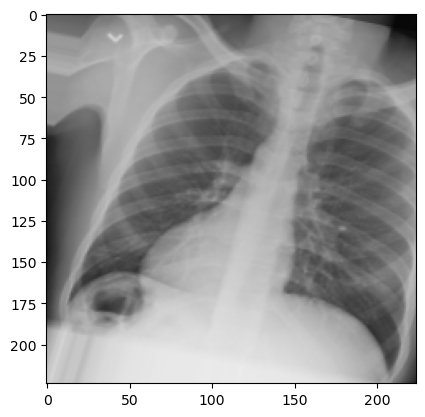

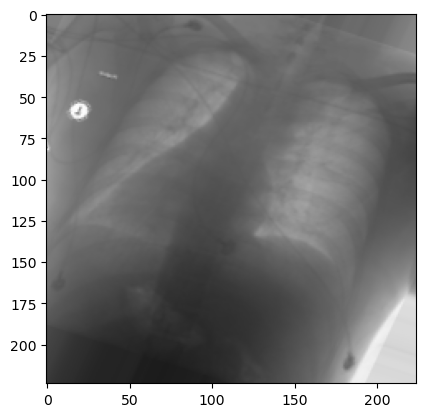

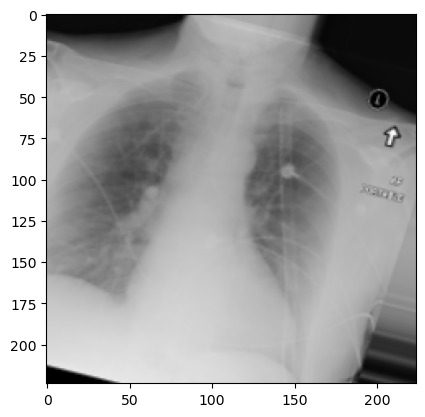

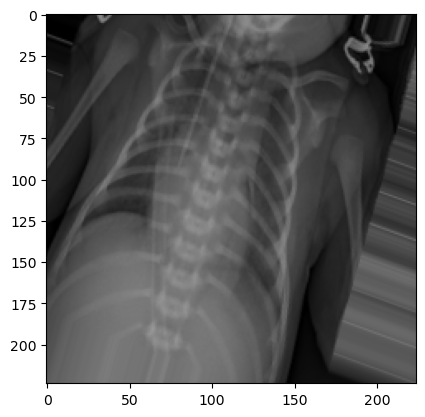

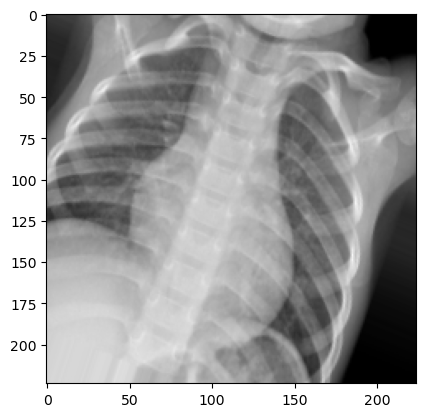

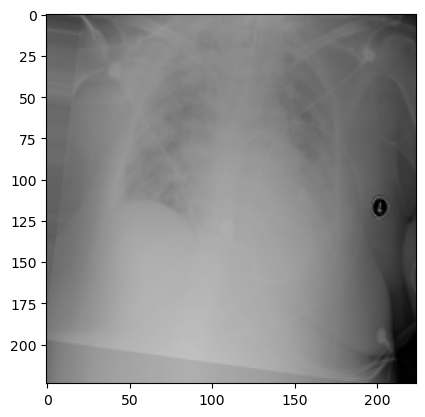

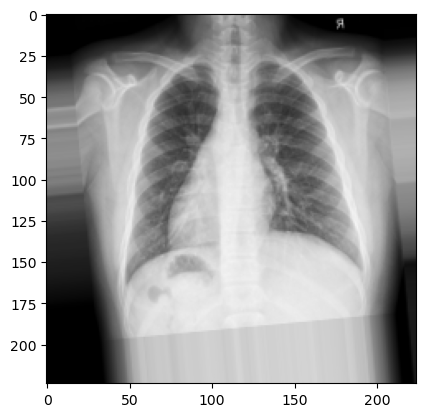

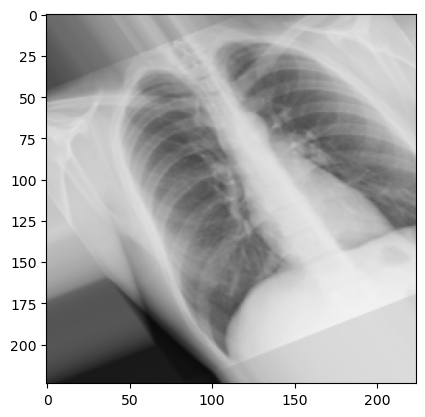

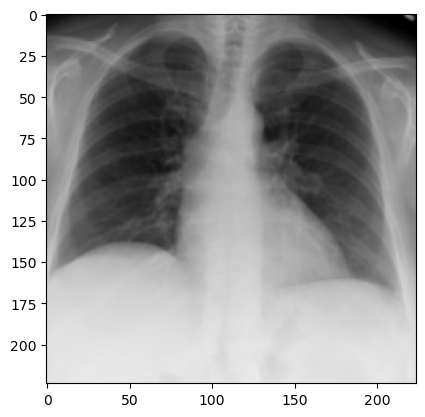

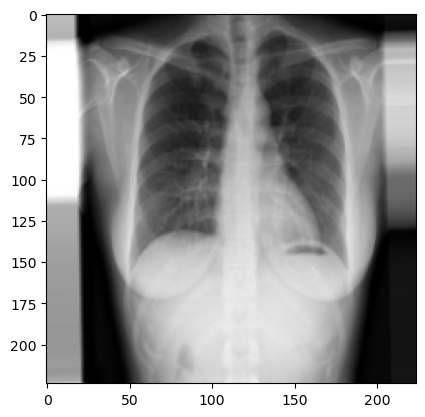

: 

In [13]:
dataset_subset = train_dataset.take(1)

# Select the pixel columns (modify if your column names are different)
labels = []
pixels = []
for image, label in dataset_subset:
    labels.append(label.numpy())
    pixels.append(image.numpy())

labels = np.array(labels)
pixels = np.array(pixels)  # Shape: (10, dimension, dimension, channels)
# Reshape data to the original image shape
pixels = pixels.reshape(-1, dimension, dimension, channels)

# Create the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range = 30,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False
)
i = 0
for batch in datagen.flow(pixels, batch_size=1):
    plt.figure(i)
    plt.imshow(batch[0].reshape(dimension, dimension, channels))
    
    i += 1
    if i % 10 == 0:
        break

plt.show()

Model training

In [ ]:
tf.keras.backend.clear_session()

logs= "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tf.profiler.experimental.start(logs)

latest_checkpoint = tf.train.latest_checkpoint("./backup")
if latest_checkpoint:
    print(f"Restoring from checkpoint: {latest_checkpoint}")
else:
    print("No checkpoint found, starting from scratch.")

base_model = MobileNetV2(input_shape=(dimension, dimension, channels), include_top=False, weights='imagenet')

data_augmentation = models.Sequential([
        layers.RandomFlip("horizontal",
                          input_shape=(dimension, dimension, channels)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

inputs = tf.keras.Input(shape=(dimension, dimension, channels))
x = data_augmentation(inputs)  # Data augmentation directly applied to inputs
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer= Adam(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics = ['accuracy',
                            BinaryAccuracy(threshold=0.25, name='binary_accuracy'),
                            FalsePositives(name='fp'),
                            FalseNegatives(name='fn'),
                            TrueNegatives(name='tn'),
                            TruePositives(name='tp'),
                            MeanSquaredError(name='Brier score'),
                            Precision(name='precision'),
                            Recall(name='recall'),
                            AUC(name='auc'),
                            AUC(name='prc', curve='PR') # precision-recall curve
                ])

checkpoint = ModelCheckpoint(r'D:\Projects\Pneumonia_ML-Tensorflow\model.keras', # your path here
                             monitor='val_accuracy',     # Accuracy on the validation set
                             save_best_only=True,        # Save only the best model
                             verbose=1,
                             save_weights_only=False,
                             mode="auto", 
                             save_freq="epoch")            

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',  # Metric
                                            patience=2,             # Number of epochs with no improvement
                                            verbose=1,              # Log output
                                            factor=0.3,             # Factor by which the learning rate will be reduced
                                            min_lr=1e-7)         # Minimum learning rate

earlystop = EarlyStopping(monitor="val_prc", 
                          verbose=1, 
                          mode="auto", 
                          patience=3,
                          restore_best_weights=True)


tensorboard = TensorBoard(log_dir=logs, profile_batch='10, 15', write_graph=True, histogram_freq = 1)

backup = BackupAndRestore(backup_dir = "./backup")

terminate = TerminateOnNaN()

if latest_checkpoint:
    model.load_weights(latest_checkpoint)


history = model.fit(train_dataset, batch_size=batch_size,
                    #epochs=initial_epochs,
                    epochs=1,
                    verbose="auto",
                    validation_data= val_dataset,
                    callbacks=[checkpoint, learning_rate_reduction, tensorboard, backup, terminate, earlystop],
                    shuffle=True)
                     
model.evaluate(test_dataset)
tf.profiler.experimental.stop()

No checkpoint found, starting from scratch.
ERROR:tensorflow:Failed to start profiler: Another profiler is running.
      9/Unknown - 37s 2s/step - loss: 7.9188 - accuracy: 0.6528 - binary_accuracy: 0.7083 - fp: 60.0000 - fn: 40.0000 - tn: 19.0000 - tp: 169.0000 - Brier score: 0.2356 - precision: 0.7380 - recall: 0.8086 - auc: 0.5710 - prc: 0.7907ERROR:tensorflow:Failed to start profiler: Another profiler is running.
     71/Unknown - 137s 2s/step - loss: 6.9948 - accuracy: 0.7685 - binary_accuracy: 0.7658 - fp: 420.0000 - fn: 106.0000 - tn: 128.0000 - tp: 1618.0000 - Brier score: 0.1645 - precision: 0.7939 - recall: 0.9385 - auc: 0.7163 - prc: 0.8784

In [ ]:
model.summary()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir D:/Projects/Pneumonia_ML-Tensorflow/logs --load_fast=false --verbosity 1

In [ ]:
dataset = load_tfrecord('data.tfrecord', batch_size=batch_size)

create_charts(model, history, dataset)

In [19]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)